# Fourier Series for continuous functions

The **goals** for this notebook is to explore the convergence of the Fourier series of continuous functions, and relate that our discussion on Banach-Steinhaus theorem.

In [1]:
# Math 725: uMass Amherst Spring 2025
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.linalg as LA
import scipy.sparse.linalg as LAS
import matplotlib.pyplot as plt

import warnings

from scipy.fft import fftfreq
from scipy.fft import fftshift, ifftshift
from scipy.fft import fft, ifft

## Fourier Series

Recall that a function $f$ has the degree $n$ trigonometric interpolation polynomial:

$$
    s_n[f](t) = \sum_{k=-n}^{n} \tilde{c}_k e^{ikt},\qquad \tilde{c}_k = \frac{1}{2\pi}\int_{-\pi}^{\pi} f(t) e^{-ikt} \mathrm{d}t.
$$

First we define some useful functions. The key are vals2coeffs and coeffs2vals which faciliate the Fourier transform i.e. map uniformly sampled function values to the corresponding Fourier coefficents. The nomenclature is as in chebfun and Lloyd Trefethen's book Approximation Theory and Approximation Practice.

## Practical Fourier Series
### Step 1: Computing the interpolating polynomial. 

In [2]:
def trigpts(N, dom=[-1, 1]):
    x = np.linspace(-np.pi, np.pi, N + 1)
    x /= np.pi
    x = (x - x[::-1]) / 2.
    x = x[:N]
    # Map to right domain
    x = np.diff(dom) * x / 2 + np.average(dom)
    return x

def trigfreq(N):
    if N & 1:
        return np.expand_dims(np.arange(-(N-1)/2, N/2), axis=1)
    else:
        return np.expand_dims(np.arange(-N/2, N/2), axis=1)

def isHerm(values):
    imag = values - np.conj(values[::-1, :])
    return np.max(np.hypot(np.real(imag), np.imag(imag)), axis=0) == 0.0

def isSkew(values):
    imag = values + np.conj(values[::-1, :])
    return np.max(np.hypot(np.real(imag), np.imag(imag)), axis=0) == 0.0

def vals2coeffs(values):
    """ Convert values at N equally spaced points between [-1, 1) to N trigonmetric coefficients

    If N is odd:
          F(x) = C(1)*z^(-(N-1)/2) + C(2)*z^(-(N-1)/2-1) + ... + C(N)*z^((N-1)/2)

    If N is even:
          F(x) = C(1)*z^(-N/2) + C(2)*z^(-N/2+1) + ... + C(N)*z^(N/2-1)

    where z = exp(1j pi x).

    F(x) interpolates the data [V(1) ; ... ; V(N)] at the N equally
    spaced points x_k = -1 + 2*k/N, k=0:N-1.
    """
    # This function expects values to be row-major oriented -> functions are column vectors.
    if values.ndim <= 1:
        values = np.expand_dims(values, axis=1)
    n = values.shape[0]

    if n <= 1:
        return np.copy(values, order='F')

    # test for symmetry
    vals = np.vstack((values, values[0, :]))
    is_herm = isHerm(vals)
    is_skew = isSkew(vals)

    # compute coefficients
    # fftshift shifts the zero-frequency component into the center of the spectrum!
    coeffs = fftshift(fft(values, axis=0, norm='forward'), axes=0)

    # correct if symmetric
    coeffs[:, is_herm] = np.real(coeffs[:, is_herm])
    coeffs[:, is_skew] = 1j * np.imag(coeffs[:, is_skew])

    # These interpolations are defined on the interval [0, 2*pi), but we want them on
    # (-pi, pi). To fix the coefficients for this we just need to assign
    # c_k = (-1)^k c_k, for k = -(N-1)/2:(N-1)/2 for N odd and k = -N/2:N/2-1 for N even
    if np.remainder(n, 2):
        even_odd_fix = np.expand_dims((-1)**np.arange(-(n-1)/2, n/2, 1), axis=1)
    else:
        even_odd_fix = np.expand_dims((-1)**np.arange(-n/2, n/2, 1), axis=1)

    coeffs = even_odd_fix * coeffs
    return coeffs

def coeffs2vals(coeffs):
    """ Convert Fourier coefficients to values at N equally spaced points between [-1, 1],
        where N is the number of coefficients. 

        This is the reverse transform from the above.
    """
    n = coeffs.shape[0]

    if n <= 1:
        return np.copy(coeffs, order='F')

    if np.remainder(n, 2):
        even_odd_fix = np.expand_dims((-1)**np.arange(-(n-1)/2, n/2, 1), axis=1)
    else:
        even_odd_fix = np.expand_dims((-1)**np.arange(-n/2, n/2, 1), axis=1)

    coeffs = even_odd_fix * coeffs

    # test for symmetry
    is_herm = np.max(np.abs(np.imag(coeffs)), axis=0) == 0.0
    is_skew = np.max(np.abs(np.real(coeffs)), axis=0) == 0.0

    # shift the coefficients properly
    values = ifft(ifftshift(coeffs, axes=0), axis=0, norm='forward')

    # correct if symmetric
    vals = np.vstack((values, values[0, :]))
    hermvals = (vals + np.flipud(np.conj(vals)))/2
    skewvals = (vals - np.flipud(np.conj(vals)))/2
    values[:, is_herm] = hermvals[:-1, is_herm]
    values[:, is_skew] = skewvals[:-1, is_skew]
    return values


### Step 2: Evaluation of trigonometric interpolants

In [3]:
def trigBaryWeights(x):
    """ 
        Baryometric Weights for the evaluation of the trigonometric interpolants 
    """
    n = x.size
    
    eps = np.finfo(float).eps
    if np.all(np.abs(np.diff(x) - 2. * np.pi / n) < np.max(np.abs(x))*eps):
        # Detect the equispaced case for the output
        w = np.ones_like(x)
        w[1::2] = -1
        return w

    # Else assemble the points in a loop
    w = np.ones(n)
    for j in range(n):
        v = np.sin(0.5 * (x[j] - x))
        v[j] = 1.0
        vv = np.exp(np.sum(np.log(np.abs(v))))
        w[j] = 1./(np.prod(np.sign(v))*vv)

    # Scale using infinity norm
    norm = np.max(np.abs(w))
    w /= norm
    return w

def trigBary(x, fvals, xk, dom=[-np.pi, np.pi]):
    """
        Evaluate the trigonometric interpolant at points x.

        fvals / xk are the data points
        dom is the domain of definition.

        x - are the points at which we wish to evaluate the function.
    """
    eps = np.finfo(float).eps
    nx = x.size
    if fvals.ndim <= 1: # Again want fvals to be a column vector
        fvals = np.expand_dims(fvals, axis=1)
    n, m = fvals.shape

    # Map inputs to [-pi, pi]
    a = dom[0]
    b = dom[1]
    xk = (2. * xk - a - b) * np.pi / (b - a)
    x  = (2. * x  - a - b) * np.pi / (b - a)

    # Get the barycentric weights
    vk = trigBaryWeights(xk)

    # Choose appropriate function based on length of values 
    # to interpolate
    if np.remainder(n, 2) == 0:
        s = np.sum(xk)
        if np.abs(np.remainder(s, np.pi)) < 4. * np.pi * eps:
            c = 0
        else:
            c = 1./np.tan(s/2)
        ctsc = lambda x: 1./np.tan(x) + c
    else:
        ctsc = lambda x: 1./np.sin(x)

    # Main loop
    num   = np.zeros_like(x)
    denom = np.zeros_like(x)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'divide by zero')
        warnings.filterwarnings('ignore', r'invalid value encountered')

        for j in range(n):
            tmp = vk[j] * ctsc((x - xk[j]) / 2.0)
            num   += tmp * np.real(fvals[j, :])
            denom += tmp

        # Compute fraction
        fx = num / denom

    # Cleanup the NaN values
    # TODO: is there a cleaner way of doing this?
    # Is the below correct?
    idx = np.where(np.isnan(fx))[0]
    for i in idx:
        index = np.where(xk == x[i])[0]
        if len(index) > 0:
            if fvals.ndim == 1:
                fx[i] = np.real(fvals[index[0]])
            elif fvals.ndim == 2:
                fx[i] = np.real(fvals[index[0], 0])
            #fx[i] = fvals[index[0], :]

    return fx


### A first Fourier series example

/usr/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


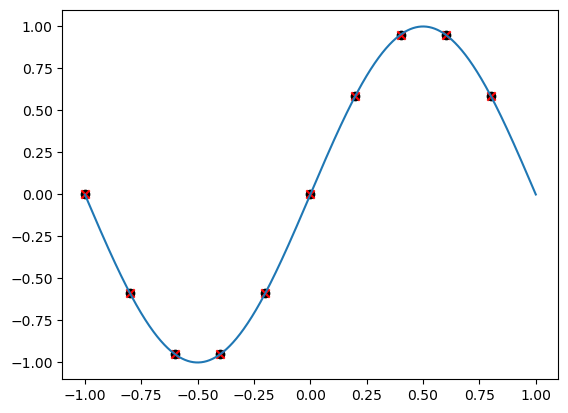

In [4]:
xk = trigpts(10)
fk = np.sin(np.pi * xk)
ck = vals2coeffs(fk)
vk = coeffs2vals(ck)

# Try some plotting
xf = np.linspace(-1, 1, 1000)
ff = trigBary(xf, fk, xk, dom=[-1, 1])

plt.scatter(xk, fk, marker='o', color='k')
plt.scatter(xk, vk, marker='x', color='r')
plt.plot(xf, ff)


### Example of Fourier coefficient decay for analytic function

/usr/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


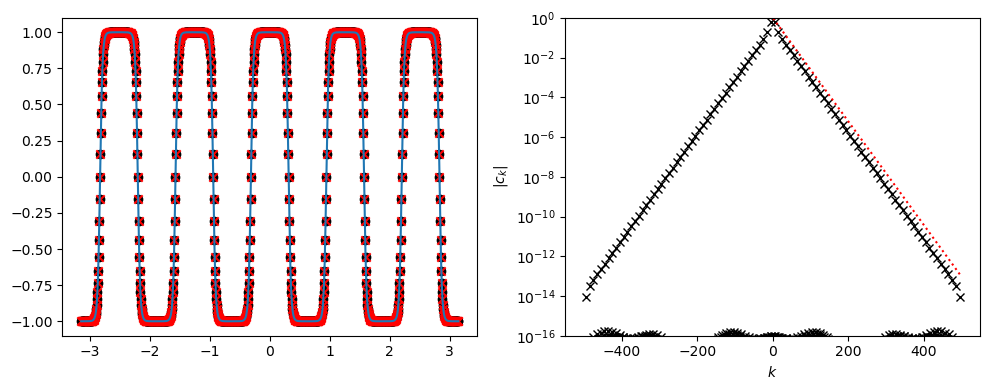

In [5]:
N  = 1000
xk = trigpts(N, dom=[-np.pi, np.pi])
ks = trigfreq(N) 
fk = np.tanh(5. * np.cos(5. * xk))
ck = vals2coeffs(fk)
vk = coeffs2vals(ck)

# Try some plotting
xf = np.linspace(-np.pi, np.pi, 1000)
ff = trigBary(xf, fk, xk, dom=[-np.pi, np.pi])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(xk, fk, marker='o', color='k')
axs[0].scatter(xk, vk, marker='x', color='r')
axs[0].plot(xf, ff)

axs[1].semilogy(ks, np.abs(ck), marker='x', lw=0, color='k')
kks = ks[ks>0]
alpha = 0.06
axs[1].semilogy(kks, np.exp(-alpha * kks), color='r', ls=':')
axs[1].set_ylabel('$|c_k|$')
axs[1].set_xlabel('$k$')
axs[1].set_ylim([1e-16, 1])
fig.tight_layout()

## Weierstrass type function

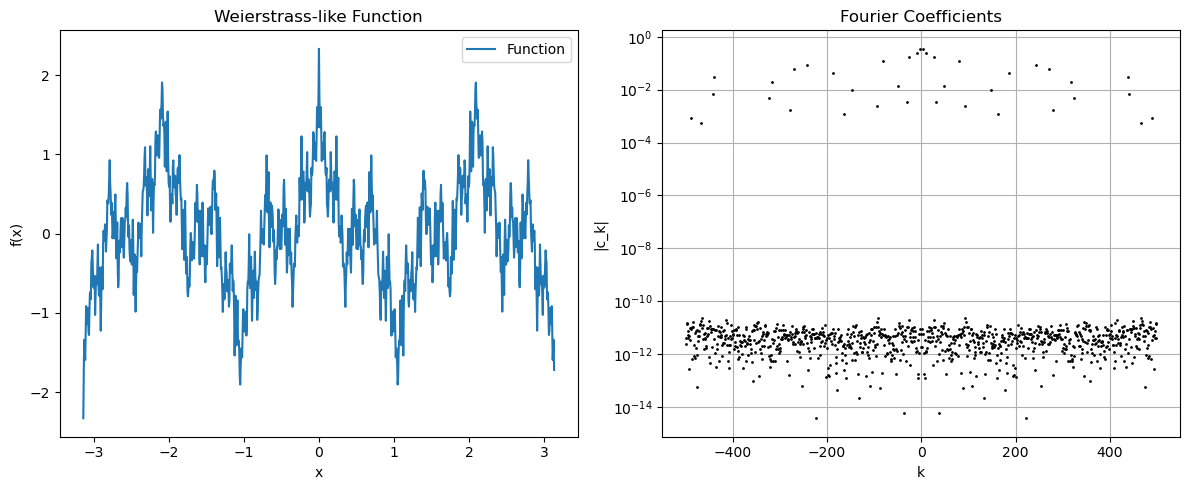

In [6]:
# Example of a continuous function with slow pointwise convergence
N = 1000
xk = trigpts(N, dom=[-np.pi, np.pi])
ks = trigfreq(N)

# Weierstrass function-inspired example (continuous but nowhere differentiable)
fk = np.zeros_like(xk)
for j in range(1, 20):
    fk += (0.7**j) * np.cos(3**j * xk)

ck = vals2coeffs(fk)
vk = coeffs2vals(ck)

# Plot the function and its Fourier coefficients
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(xk, fk, label='Function')
axs[0].set_title('Weierstrass-like Function')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].legend()

# Plot the absolute values of the coefficients
axs[1].semilogy(ks, np.abs(ck), 'k.', markersize=2)
axs[1].set_title('Fourier Coefficients')
axs[1].set_xlabel('k')
axs[1].set_ylabel('|c_k|')
axs[1].grid(True)
fig.tight_layout()

## Du-Bois type function

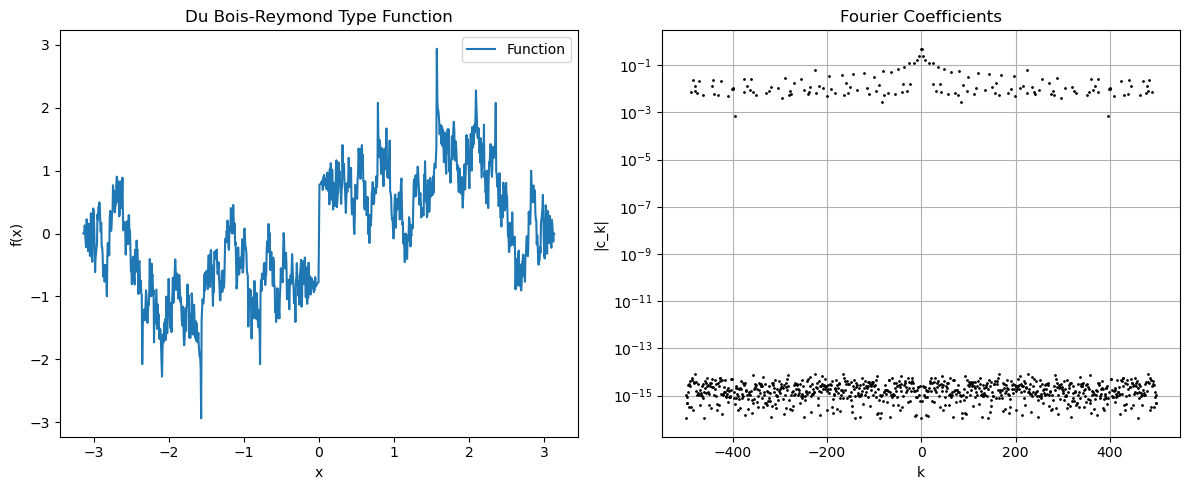

In [7]:
# Du Bois-Reymond type function
N = 1000
xk = trigpts(N, dom=[-np.pi, np.pi])
ks = trigfreq(N)

# Create a function with slowly decaying Fourier coefficients
fk = np.zeros_like(xk)
for j in range(1, 100):
    fk += np.sin(j**2 * xk) / j

ck = vals2coeffs(fk)
vk = coeffs2vals(ck)

# Plot the function and its Fourier coefficients
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(xk, fk, label='Function')
axs[0].set_title('Du Bois-Reymond Type Function')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].legend()

# Plot the absolute values of the coefficients
axs[1].semilogy(ks, np.abs(ck), 'k.', markersize=2)
axs[1].set_title('Fourier Coefficients')
axs[1].set_xlabel('k')
axs[1].set_ylabel('|c_k|')
axs[1].grid(True)
fig.tight_layout()

## Evaluating the convergence of the Fourier partial sums at a point.

In [ ]:
# Visualizing the growth of partial sums
N = 1000
xk = trigpts(N, dom=[-np.pi, np.pi])
ks = trigfreq(N)

# Create a continuous function with interesting Fourier behavior
def create_pathological_function(x):
    return np.sum([np.sin(k**2 * x)/k for k in range(1, 50)])

# Make sure fk is properly shaped for vals2coeffs
fk = np.array([create_pathological_function(x) for x in xk])
ck = vals2coeffs(fk)

# Choose a specific point to evaluate the partial sums
x0 = 0.5  # point where we'll evaluate all partial sums
partial_sums = []
term_counts = list(range(1, 751))  

# Calculate the actual function value at x0
actual_value = create_pathological_function(x0)

for n in term_counts:
    # Truncate coefficients to create partial sum
    ck_truncated = ck.copy()
    mid_idx = len(ck) // 2
    for j in range(len(ck)):
        if abs(j - mid_idx) > n:
            ck_truncated[j] = 0
    
    # Convert back to values
    reconstruction = coeffs2vals(ck_truncated)
    
    # Handle potential shape issues with trigBary
    reconstruction = reconstruction.flatten() if reconstruction.ndim > 1 else reconstruction
    
    # Evaluate at x0
    point_value = np.real(trigBary(np.array([x0]), reconstruction, xk, dom=[-np.pi, np.pi])[0])
    partial_sums.append(point_value)

# Plot the behavior of partial sums
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot function
axs[0].plot(xk, fk)
axs[0].axvline(x0, color='r', linestyle='--', label=f'x = {x0}')
axs[0].axhline(actual_value, color='g', linestyle='--', label=f'f({x0}) = {actual_value:.4f}')
axs[0].plot(x0, actual_value, 'ro', markersize=6)  # Add point at (x0, f(x0))
axs[0].set_title('Function')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].legend()
axs[0].grid(True)

# Plot partial sums
axs[1].plot(term_counts, partial_sums)
axs[1].axhline(actual_value, color='g', linestyle='--', label=f'f({x0}) = {actual_value:.4f}')
axs[1].set_title(f'Partial Sums at x = {x0}')
axs[1].set_xlabel('Number of terms')
axs[1].set_ylabel('Value of partial sum')
axs[1].grid(True)

# Also plot the running max to visualize s*(f,x)
running_max = np.maximum.accumulate(np.abs(partial_sums))
axs[1].plot(term_counts, running_max, 'r--', label='Running max (s*(f,x))')
axs[1].legend()

fig.tight_layout()

### Can we make this worst?

Note that we are effectively creating sequences of continuous functions whose Fourier coefficients decay slower and slower, so that we somehow converge to something that is only continuous (if we could create formal limits on a computer).

In [ ]:
# Creating a function with dramatically oscillating partial sums
N = 1000
xk = trigpts(N, dom=[-np.pi, np.pi])
ks = trigfreq(N)

# Function designed to have slowly decaying coefficients with specific phase relationships
def create_oscillating_partial_sums(x):
    result = 0
    for k in range(1, 200):
        # Use logarithmic decay - slower than 1/k
        result += np.sin(k*x + np.pi/4*k) / np.log(k+1)**0.8
    return result

# Make sure fk is properly shaped
fk = create_oscillating_partial_sums(xk)
ck = vals2coeffs(fk)

# Choose a specific point to evaluate the partial sums
x0 = 0.0
partial_sums = []
term_counts = list(range(1, 301))  # Examine more terms to see the pattern

# Calculate the actual function value at x0
actual_value = create_oscillating_partial_sums(x0)

for n in term_counts:
    # Truncate coefficients to create partial sum
    ck_truncated = ck.copy()
    mid_idx = len(ck) // 2
    for j in range(len(ck)):
        if abs(j - mid_idx) > n:
            ck_truncated[j] = 0
    
    # Convert back to values
    reconstruction = coeffs2vals(ck_truncated)
    reconstruction = reconstruction.flatten() if reconstruction.ndim > 1 else reconstruction
    
    # Evaluate at x0
    point_value = np.real(trigBary(np.array([x0]), reconstruction, xk, dom=[-np.pi, np.pi])[0])
    partial_sums.append(point_value)

# Plot the behavior of partial sums
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot function
axs[0].plot(xk, fk)
axs[0].axvline(x0, color='r', linestyle='--', label=f'x = {x0}')
axs[0].axhline(actual_value, color='g', linestyle='--', label=f'f({x0}) = {actual_value:.4f}')
axs[0].plot(x0, actual_value, 'ro', markersize=6)
axs[0].set_title('Function with Slowly Decaying Coefficients')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].legend()
axs[0].grid(True)

# Plot partial sums
axs[1].plot(term_counts, partial_sums)
axs[1].axhline(actual_value, color='g', linestyle='--', label=f'f({x0}) = {actual_value:.4f}')
axs[1].set_title(f'Partial Sums at x = {x0}')
axs[1].set_xlabel('Number of terms')
axs[1].set_ylabel('Value of partial sum')
axs[1].grid(True)

# Calculate maximum deviation from the actual value
deviations = np.abs(np.array(partial_sums) - actual_value)
max_deviation = np.max(deviations)
max_deviation_index = np.argmax(deviations)

# Annotate the maximum deviation
axs[1].plot(term_counts[max_deviation_index], partial_sums[max_deviation_index], 'ro', markersize=6)

# Plot running max to visualize s*(f,x)
running_max = np.maximum.accumulate(np.abs(partial_sums))
axs[1].plot(term_counts, running_max, 'r--', label='Running max (s*(f,x))')
axs[1].legend()

fig.tight_layout()

## Gibbs-phenomena

In [ ]:
from scipy import signal

# Gibbs phenomenon visualization
N = 1000
xk = trigpts(N, dom=[-np.pi, np.pi])
ks = trigfreq(N)

# Square wave (discontinuous)
fk = signal.square(xk)
ck = vals2coeffs(fk)

# Create reconstructions with different numbers of terms
xf = np.linspace(-np.pi, np.pi, 2000)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Original function
axs[0, 0].plot(xk, fk, 'k-', label='Original')
axs[0, 0].set_title('Square Wave')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('f(x)')
axs[0, 0].grid(True)

# Reconstructions with different numbers of terms
term_counts = [5, 15, 50]
for i, num_terms in enumerate(term_counts):
    row, col = (i+1) // 2, (i+1) % 2
    
    # Truncate coefficients to create partial sum
    ck_truncated = ck.copy()
    # Keep only the first num_terms coefficients (centered)
    mid_idx = len(ck) // 2
    for j in range(len(ck)):
        if abs(j - mid_idx) > num_terms:
            ck_truncated[j] = 0
    
    # Convert back to values
    reconstruction = coeffs2vals(ck_truncated)
    
    # Smooth reconstruction for plotting
    ff = trigBary(xf, reconstruction, xk, dom=[-np.pi, np.pi])
    
    # Plot
    axs[row, col].plot(xf, ff, 'b-', label=f'{num_terms} terms')
    axs[row, col].plot(xk, fk, 'k--', alpha=0.5, label='Original')
    axs[row, col].set_title(f'Reconstruction with {num_terms} terms')
    axs[row, col].set_xlabel('x')
    axs[row, col].set_ylabel('f(x)')
    axs[row, col].grid(True)
    axs[row, col].legend()
    
    # Zoom in on the discontinuity to see the Gibbs oscillations
    axs[row, col].set_xlim(-np.pi/4, np.pi/4)
    axs[row, col].set_ylim(-1.5, 1.5)

fig.tight_layout()